In [54]:
"""
BLOCK 1: INSTALLATION & SETUP
==============================
Install required packages for the classification pipeline
"""

# Install required packages
!pip install -q scikit-learn pandas numpy matplotlib seaborn wandb nltk pyarrow fastparquet

# Download NLTK data
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("All packages installed successfully!")

All packages installed successfully!


In [55]:
"""
BLOCK 2: IMPORT LIBRARIES
=========================
Import all necessary libraries for the classification pipeline
"""

import os
import json
import re
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_recall_fscore_support
)

# NLP Processing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Sparse matrix operations
from scipy.sparse import hstack

# Experiment tracking
import wandb

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully!")
print(f"Random seed set to: {RANDOM_STATE}")

All libraries imported successfully!
Random seed set to: 42


In [56]:
import zipfile
import os
import shutil

"""
BLOCK 3: UNZIP DATASET & SET DATA PATH
=====================================
Unzips dataset.zip, normalizes folder structure,
and sets DATA_PATH for training/testing.
"""

ZIP_PATH = 'dataset.zip'
TEMP_EXTRACT_DIR = './_extracted'
FINAL_DATA_PATH = './math'
SOURCE_DIR = os.path.join(TEMP_EXTRACT_DIR, 'MATH')

# Step 1: Unzip dataset if needed
if not os.path.exists(FINAL_DATA_PATH):
    if not os.path.exists(TEMP_EXTRACT_DIR):
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(TEMP_EXTRACT_DIR)
        print(" Dataset unzipped")
    else:
        print(" Dataset already extracted")

    # Step 2: Move MATH → math
    if os.path.exists(SOURCE_DIR):
        shutil.move(SOURCE_DIR, FINAL_DATA_PATH)
        print(" Dataset moved to ./math/")
    else:
        raise FileNotFoundError(" MATH folder not found inside dataset.zip")

    # Step 3: Cleanup temp files
    shutil.rmtree(TEMP_EXTRACT_DIR)
    print("🧹 Temporary extraction folder removed")
else:
    print("ℹ./math/ already exists, skipping unzip")

# Step 4: Set DATA_PATH
DATA_PATH = FINAL_DATA_PATH

# Step 5: Sanity checks
assert os.path.isdir(os.path.join(DATA_PATH, 'train')), " train/ folder missing"
assert os.path.isdir(os.path.join(DATA_PATH, 'test')), " test/ folder missing"

print("\n🎯 Data path set successfully!")
print(f"📁 DATA_PATH: {DATA_PATH}")


ℹ./math/ already exists, skipping unzip

🎯 Data path set successfully!
📁 DATA_PATH: ./math


In [57]:
"""
BLOCK 4: CONVERT JSON TO PARQUET
=================================
Convert JSON files to Parquet format for faster loading
"""

def json_to_parquet(data_path: str):
    """Convert all JSON files to Parquet format"""
    data_path = Path(data_path)

    train_path = data_path / 'train'
    test_path = data_path / 'test'

    if not train_path.exists():
        print(f"ERROR: Train path {train_path} does not exist")
        return

    topics = [d.name for d in train_path.iterdir()
             if d.is_dir() and not d.name.startswith('.')]
    topics = sorted(topics)

    print(f"Discovered {len(topics)} topics: {topics}")
    print("\nConverting JSON to Parquet...")

    for split in ['train', 'test']:
        split_path = data_path / split
        data = []

        print(f"\nProcessing {split} data...")
        for topic in topics:
            topic_path = split_path / topic

            if not topic_path.exists():
                print(f"  WARNING: {topic} directory not found in {split}")
                continue

            json_files = list(topic_path.glob('*.json'))
            print(f"  {topic}: {len(json_files)} files")

            for json_file in json_files:
                try:
                    with open(json_file, 'r', encoding='utf-8') as f:
                        problem_data = json.load(f)
                        problem_data['topic'] = topic
                        problem_data['split'] = split
                        data.append(problem_data)
                except Exception as e:
                    print(f"  ERROR loading {json_file}: {e}")

        df = pd.DataFrame(data)
        parquet_file = data_path / f'{split}.parquet'
        df.to_parquet(parquet_file, engine='pyarrow', compression='snappy')

        print(f"  Saved {len(df)} samples to {parquet_file}")

    print("\nConversion complete!")

json_to_parquet(DATA_PATH)

Discovered 7 topics: ['algebra', 'counting_and_probability', 'geometry', 'intermediate_algebra', 'number_theory', 'prealgebra', 'precalculus']

Converting JSON to Parquet...

Processing train data...
  algebra: 1744 files
  counting_and_probability: 771 files
  geometry: 870 files
  intermediate_algebra: 1295 files
  number_theory: 869 files
  prealgebra: 1205 files
  precalculus: 746 files
  Saved 7500 samples to math/train.parquet

Processing test data...
  algebra: 1187 files
  counting_and_probability: 474 files
  geometry: 479 files
  intermediate_algebra: 903 files
  number_theory: 540 files
  prealgebra: 871 files
  precalculus: 546 files
  Saved 5000 samples to math/test.parquet

Conversion complete!


In [58]:
"""
BLOCK 5: DATASET LOADER CLASS
==============================
Load dataset from Parquet files
"""

class MathDatasetLoader:
    """Load math question dataset from Parquet files"""

    def __init__(self, data_path: str):
        self.data_path = Path(data_path)
        self.train_file = self.data_path / 'train.parquet'
        self.test_file = self.data_path / 'test.parquet'

    def load_all_data(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Load both train and test datasets from Parquet files"""
        print("="*80)
        print("LOADING DATASET FROM PARQUET FILES")
        print("="*80)

        print(f"\nLoading training data from {self.train_file}")
        train_df = pd.read_parquet(self.train_file)
        print(f"Training samples loaded: {len(train_df)}")

        print(f"\nLoading test data from {self.test_file}")
        test_df = pd.read_parquet(self.test_file)
        print(f"Test samples loaded: {len(test_df)}")

        return train_df, test_df

    def explore_dataset(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
        """Display dataset statistics"""
        print("\n" + "="*80)
        print("DATASET STATISTICS")
        print("="*80)

        print(f"\nTraining set shape: {train_df.shape}")
        print(f"Test set shape: {test_df.shape}")

        print("\n--- Training Set Class Distribution ---")
        train_dist = train_df['topic'].value_counts()
        print(train_dist)

        print("\n--- Test Set Class Distribution ---")
        test_dist = test_df['topic'].value_counts()
        print(test_dist)

        # Visualizations
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        train_dist.plot(kind='bar', ax=axes[0], color='steelblue')
        axes[0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Topic')
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(axis='y', alpha=0.3)

        test_dist.plot(kind='bar', ax=axes[1], color='coral')
        axes[1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Topic')
        axes[1].set_ylabel('Count')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

        return train_dist, test_dist

print("MathDatasetLoader class defined!")

MathDatasetLoader class defined!


In [59]:
"""
BLOCK 6: FEATURE EXTRACTION CLASS
==================================
Extract features from mathematical text
"""

class MathFeatureExtractor:
    """Extract features from math problems"""

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_latex(self, text: str) -> str:
        """Remove or simplify LaTeX commands"""
        text = re.sub(r'\\[a-zA-Z]+\{([^}]*)\}', r'\1', text)
        text = re.sub(r'\\[a-zA-Z]+', ' ', text)
        text = re.sub(r'[\{\}\$\\]', ' ', text)
        return text

    def extract_math_symbols(self, text: str) -> Dict[str, int]:
        """Extract mathematical symbols as binary features"""
        symbols = {
            'has_fraction': int('frac' in text or '/' in text),
            'has_sqrt': int('sqrt' in text or '√' in text),
            'has_exponent': int('^' in text or 'pow' in text),
            'has_integral': int('int' in text or '∫' in text),
            'has_derivative': int("'" in text or 'prime' in text),
            'has_summation': int('sum' in text or '∑' in text),
            'has_pi': int('pi' in text or 'π' in text),
            'has_trigonometric': int(any(t in text.lower() for t in ['sin', 'cos', 'tan'])),
            'has_inequality': int(any(s in text for s in ['<', '>', 'leq', 'geq', '≤', '≥'])),
            'has_absolute': int('abs' in text or '|' in text),
        }
        return symbols

    def extract_numeric_features(self, text: str) -> Dict[str, float]:
        """Extract numeric features from text"""
        numbers = re.findall(r'-?\d+\.?\d*', text)
        return {
            'num_count': len(numbers),
            'has_large_numbers': int(any(float(n) > 100 for n in numbers if n)),
            'has_decimals': int(any('.' in n for n in numbers)),
            'has_negatives': int(any(n.startswith('-') for n in numbers)),
            'avg_number': np.mean([float(n) for n in numbers]) if numbers else 0,
        }

    def preprocess_text(self, text: str) -> str:
        """Clean and preprocess text"""
        text = self.clean_latex(text)
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        words = text.split()
        words = [self.lemmatizer.lemmatize(w) for w in words
                if w not in self.stop_words and len(w) > 2]
        return ' '.join(words)

print("MathFeatureExtractor class defined!")

MathFeatureExtractor class defined!


In [60]:
"""
BLOCK 7: CLASSIFIER CLASS
=========================
Train and evaluate classification models
"""

class MathQuestionClassifier:
    """Train and evaluate classification models"""

    def __init__(self, use_wandb: bool = False):
        self.feature_extractor = MathFeatureExtractor()
        self.label_encoder = LabelEncoder()
        self.best_model = None
        self.vectorizer = None
        self.scaler = None
        self.use_wandb = use_wandb

        self.vectorizer_config = {
            'max_features': 5000,
            'ngram_range': (1, 3),
            'min_df': 2,
            'max_df': 0.95,
            'sublinear_tf': True
        }

    def prepare_features(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, np.ndarray]:
        """Prepare features WITHOUT vectorization"""
        print("\n" + "="*80)
        print("FEATURE ENGINEERING")
        print("="*80)

        print("\nPreprocessing text...")
        df['processed_text'] = df['problem'].apply(
            self.feature_extractor.preprocess_text
        )

        print("Extracting mathematical symbol features...")
        math_symbols = df['problem'].apply(
            self.feature_extractor.extract_math_symbols
        )

        print("Extracting numeric features...")
        numeric_features = df['problem'].apply(
            self.feature_extractor.extract_numeric_features
        )

        symbol_df = pd.DataFrame(list(math_symbols))
        numeric_df = pd.DataFrame(list(numeric_features))

        additional_features = np.hstack([
            symbol_df.values,
            numeric_df.values
        ])

        for i, col in enumerate(list(symbol_df.columns) + list(numeric_df.columns)):
            df[f'feature_{col}'] = additional_features[:, i]

        y = self.label_encoder.fit_transform(df['topic'])

        print(f"\nProcessed {len(df)} samples")
        print(f"Number of classes: {len(np.unique(y))}")

        return df, y

    def vectorize_features(self, train_df: pd.DataFrame, test_df: pd.DataFrame = None):
        """Vectorize features with proper train/test separation"""
        print("\n--- TF-IDF Vectorization ---")

        self.vectorizer = TfidfVectorizer(**self.vectorizer_config)

        X_train_text = self.vectorizer.fit_transform(train_df['processed_text'])
        print(f"Training TF-IDF shape: {X_train_text.shape}")
        print(f"Vocabulary size: {len(self.vectorizer.get_feature_names_out())}")

        feature_cols = [c for c in train_df.columns if c.startswith('feature_')]
        X_train_additional = train_df[feature_cols].values

        self.scaler = MinMaxScaler()
        X_train_additional_scaled = self.scaler.fit_transform(X_train_additional)

        X_train = hstack([X_train_text, X_train_additional_scaled])

        if test_df is not None:
            X_test_text = self.vectorizer.transform(test_df['processed_text'])
            X_test_additional = test_df[feature_cols].values
            X_test_additional_scaled = self.scaler.transform(X_test_additional)
            X_test = hstack([X_test_text, X_test_additional_scaled])
            print(f"Test TF-IDF shape: {X_test_text.shape}")
            return X_train, X_test

        return X_train

    def train_models(self, X_train, y_train, X_test, y_test, dataset_info: dict = None):
        """Train and compare models"""
        print("\n" + "="*80)
        print("MODEL TRAINING")
        print("="*80)

        n_samples = X_train.shape[0]
        n_features = X_train.shape[1]
        n_classes = len(np.unique(y_train))

        print(f"\nDataset Statistics:")
        print(f"   Training samples: {n_samples}")
        print(f"   Features: {n_features}")
        print(f"   Classes: {n_classes}")

        models = {
            'Naive Bayes': MultinomialNB(alpha=0.1, fit_prior=True),
            'Logistic Regression': LogisticRegression(
                max_iter=1000, C=1.0, solver='saga',
                random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1
            ),
            'SVM': SVC(
                kernel='linear', C=1.0, random_state=RANDOM_STATE,
                class_weight='balanced', probability=True
            ),
            'Random Forest': RandomForestClassifier(
                n_estimators=200, max_depth=30, min_samples_split=5,
                min_samples_leaf=2, max_features='sqrt',
                random_state=RANDOM_STATE, class_weight='balanced',
                n_jobs=-1, bootstrap=True
            ),
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1, max_depth=7,
                min_samples_split=5, min_samples_leaf=2,
                subsample=0.8, max_features='sqrt',
                random_state=RANDOM_STATE
            )
        }

        results = {}

        for name, model in models.items():
            print(f"\nTraining {name}...")

            if self.use_wandb:
                run = wandb.init(project="math-question-classifier", name=name, reinit=True)
                wandb.config.update({
                    "model_name": name,
                    "train_size": X_train.shape[0],
                    "n_features": X_train.shape[1],
                    "n_classes": n_classes
                })

            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time

            y_pred = model.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')

            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'f1_score': f1,
                'training_time': training_time,
                'predictions': y_pred
            }

            print(f"   Accuracy: {accuracy:.4f}")
            print(f"   F1 Score: {f1:.4f}")
            print(f"   Training Time: {training_time:.2f}s")

            if self.use_wandb:
                wandb.log({'accuracy': accuracy, 'f1_score': f1, 'training_time': training_time})
                wandb.finish()

        best_name = max(results, key=lambda x: results[x]['f1_score'])
        self.best_model = results[best_name]['model']

        print(f"\n{'='*80}")
        print(f"BEST MODEL: {best_name}")
        print(f"F1 Score: {results[best_name]['f1_score']:.4f}")
        print(f"{'='*80}")

        return results, best_name

    def evaluate_model(self, model, X_test, y_test, model_name: str):
        """Detailed evaluation"""
        y_pred = model.predict(X_test)

        print(f"\n{'='*80}")
        print(f"EVALUATION: {model_name}")
        print(f"{'='*80}")

        print("\n--- Classification Report ---")
        print(classification_report(
            y_test, y_pred,
            target_names=self.label_encoder.classes_,
            digits=4
        ))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=self.label_encoder.classes_,
            yticklabels=self.label_encoder.classes_,
            cbar_kws={'label': 'Count'}
        )
        plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        precision, recall, f1, support = precision_recall_fscore_support(
            y_test, y_pred, labels=np.unique(y_test)
        )

        metrics_df = pd.DataFrame({
            'Class': self.label_encoder.classes_,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': support
        })

        print("\n--- Per-Class Metrics ---")
        print(metrics_df.to_string(index=False))

        return metrics_df

print("MathQuestionClassifier class defined!")

MathQuestionClassifier class defined!


LOADING DATASET FROM PARQUET FILES

Loading training data from math/train.parquet
Training samples loaded: 7500

Loading test data from math/test.parquet
Test samples loaded: 5000

DATASET STATISTICS

Training set shape: (7500, 6)
Test set shape: (5000, 6)

--- Training Set Class Distribution ---
topic
algebra                     1744
intermediate_algebra        1295
prealgebra                  1205
geometry                     870
number_theory                869
counting_and_probability     771
precalculus                  746
Name: count, dtype: int64

--- Test Set Class Distribution ---
topic
algebra                     1187
intermediate_algebra         903
prealgebra                   871
precalculus                  546
number_theory                540
geometry                     479
counting_and_probability     474
Name: count, dtype: int64


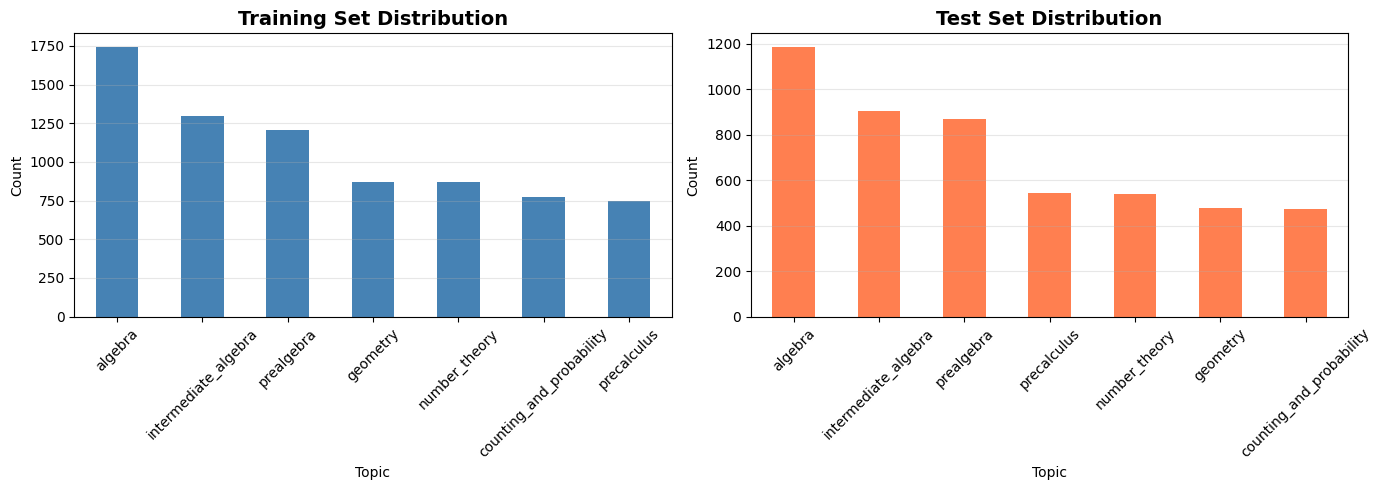


Dataset loaded successfully!
   Training samples: 7500
   Test samples: 5000
   Number of topics: 7


In [61]:
"""
BLOCK 8: LOAD DATASET
=====================
Load pre-split train and test datasets
"""

loader = MathDatasetLoader(DATA_PATH)
train_df, test_df = loader.load_all_data()

if len(train_df) == 0 or len(test_df) == 0:
    print("\nERROR: No data loaded!")
else:
    train_dist, test_dist = loader.explore_dataset(train_df, test_df)

    print(f"\nDataset loaded successfully!")
    print(f"   Training samples: {len(train_df)}")
    print(f"   Test samples: {len(test_df)}")
    print(f"   Number of topics: {train_df['topic'].nunique()}")

In [62]:
"""
BLOCK 9: PREPARE FEATURES
=========================
Extract features from train and test datasets
"""

classifier = MathQuestionClassifier(use_wandb=False)

print("\nProcessing TRAINING set...")
train_df_features, y_train = classifier.prepare_features(train_df)

print("\nProcessing TEST set...")
test_df_features, y_test = classifier.prepare_features(test_df)

print(f"\nFeature preparation complete!")
print(f"   Training samples: {len(train_df_features)}")
print(f"   Test samples: {len(test_df_features)}")
print(f"   Number of classes: {len(np.unique(y_train))}")
print(f"   Class labels: {classifier.label_encoder.classes_}")


Processing TRAINING set...

FEATURE ENGINEERING

Preprocessing text...
Extracting mathematical symbol features...
Extracting numeric features...

Processed 7500 samples
Number of classes: 7

Processing TEST set...

FEATURE ENGINEERING

Preprocessing text...
Extracting mathematical symbol features...
Extracting numeric features...

Processed 5000 samples
Number of classes: 7

Feature preparation complete!
   Training samples: 7500
   Test samples: 5000
   Number of classes: 7
   Class labels: ['algebra' 'counting_and_probability' 'geometry' 'intermediate_algebra'
 'number_theory' 'prealgebra' 'precalculus']


In [63]:
"""
BLOCK 10: VECTORIZE FEATURES
============================
Create TF-IDF features
"""

X_train, X_test = classifier.vectorize_features(train_df_features, test_df_features)

# Convert to CSR format for efficient operations
X_train = X_train.tocsr()
X_test = X_test.tocsr()

print(f"\nVectorization complete!")
print(f"   Training features: {X_train.shape}")
print(f"   Test features: {X_test.shape}")
print(f"   Format: CSR (Compressed Sparse Row)")


--- TF-IDF Vectorization ---
Training TF-IDF shape: (7500, 5000)
Vocabulary size: 5000
Test TF-IDF shape: (5000, 5000)

Vectorization complete!
   Training features: (7500, 5015)
   Test features: (5000, 5015)
   Format: CSR (Compressed Sparse Row)



MODEL TRAINING

Dataset Statistics:
   Training samples: 7500
   Features: 5015
   Classes: 7

Training Naive Bayes...
   Accuracy: 0.6588
   F1 Score: 0.6491
   Training Time: 0.01s

Training Logistic Regression...
   Accuracy: 0.6930
   F1 Score: 0.6892
   Training Time: 15.84s

Training SVM...
   Accuracy: 0.7056
   F1 Score: 0.7028
   Training Time: 49.11s

Training Random Forest...
   Accuracy: 0.6500
   F1 Score: 0.6430
   Training Time: 3.19s

Training Gradient Boosting...
   Accuracy: 0.7044
   F1 Score: 0.7040
   Training Time: 5.12s

BEST MODEL: Gradient Boosting
F1 Score: 0.7040

MODEL COMPARISON

              Model  Accuracy  F1-Score  Training Time (s)
  Gradient Boosting    0.7044  0.703957           5.117404
                SVM    0.7056  0.702767          49.113254
Logistic Regression    0.6930  0.689196          15.838561
        Naive Bayes    0.6588  0.649144           0.014010
      Random Forest    0.6500  0.642970           3.193031


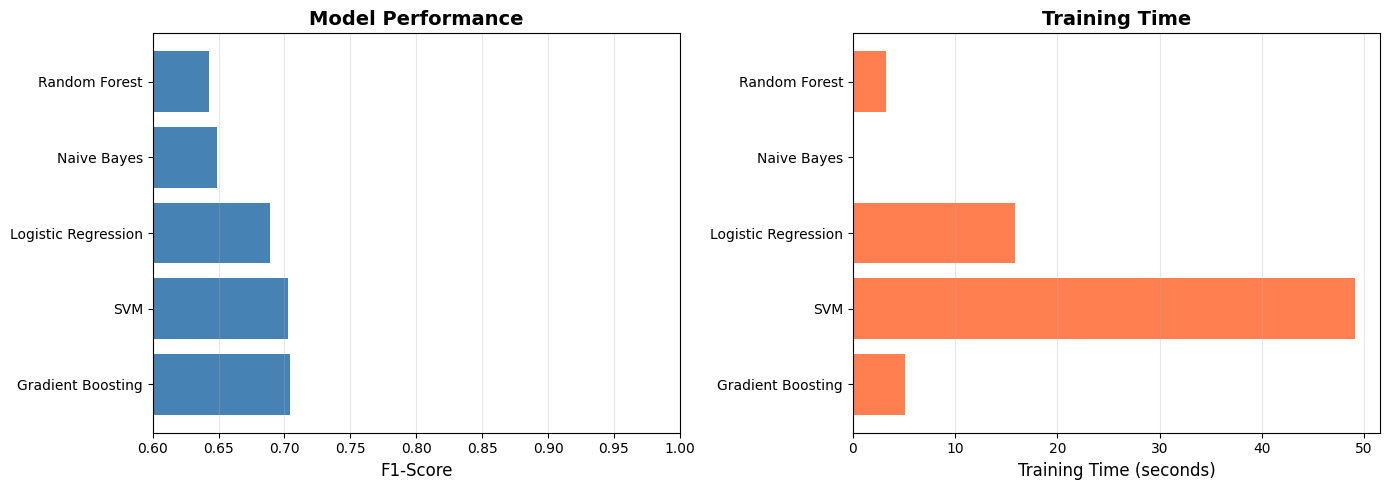


Best Model: Gradient Boosting
   F1-Score: 0.7040
   Accuracy: 0.7044


In [64]:
"""
BLOCK 11: TRAIN MODELS
======================
Train and compare classification models
"""

dataset_info = {
    'total_samples': len(train_df) + len(test_df),
    'train_samples': len(train_df),
    'test_samples': len(test_df),
    'n_topics': len(train_df['topic'].unique()),
    'topics': list(train_df['topic'].unique())
}

results, best_name = classifier.train_models(
    X_train, y_train, X_test, y_test, dataset_info
)

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1-Score': [results[m]['f1_score'] for m in results],
    'Training Time (s)': [results[m]['training_time'] for m in results]
}).sort_values('F1-Score', ascending=False)

print("\n" + comparison_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(comparison_df['Model'], comparison_df['F1-Score'], color='steelblue')
axes[0].set_xlabel('F1-Score', fontsize=12)
axes[0].set_title('Model Performance', fontsize=14, fontweight='bold')
axes[0].set_xlim([0.6, 1.0])
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(comparison_df['Model'], comparison_df['Training Time (s)'], color='coral')
axes[1].set_xlabel('Training Time (seconds)', fontsize=12)
axes[1].set_title('Training Time', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Model: {best_name}")
print(f"   F1-Score: {results[best_name]['f1_score']:.4f}")
print(f"   Accuracy: {results[best_name]['accuracy']:.4f}")


EVALUATION: Gradient Boosting

--- Classification Report ---
                          precision    recall  f1-score   support

                 algebra     0.6452    0.7767    0.7049      1187
counting_and_probability     0.8049    0.6962    0.7466       474
                geometry     0.6940    0.7432    0.7177       479
    intermediate_algebra     0.7828    0.7542    0.7682       903
           number_theory     0.7347    0.7537    0.7441       540
              prealgebra     0.5560    0.4960    0.5243       871
             precalculus     0.8814    0.7216    0.7936       546

                accuracy                         0.7044      5000
               macro avg     0.7284    0.7059    0.7142      5000
            weighted avg     0.7098    0.7044    0.7040      5000



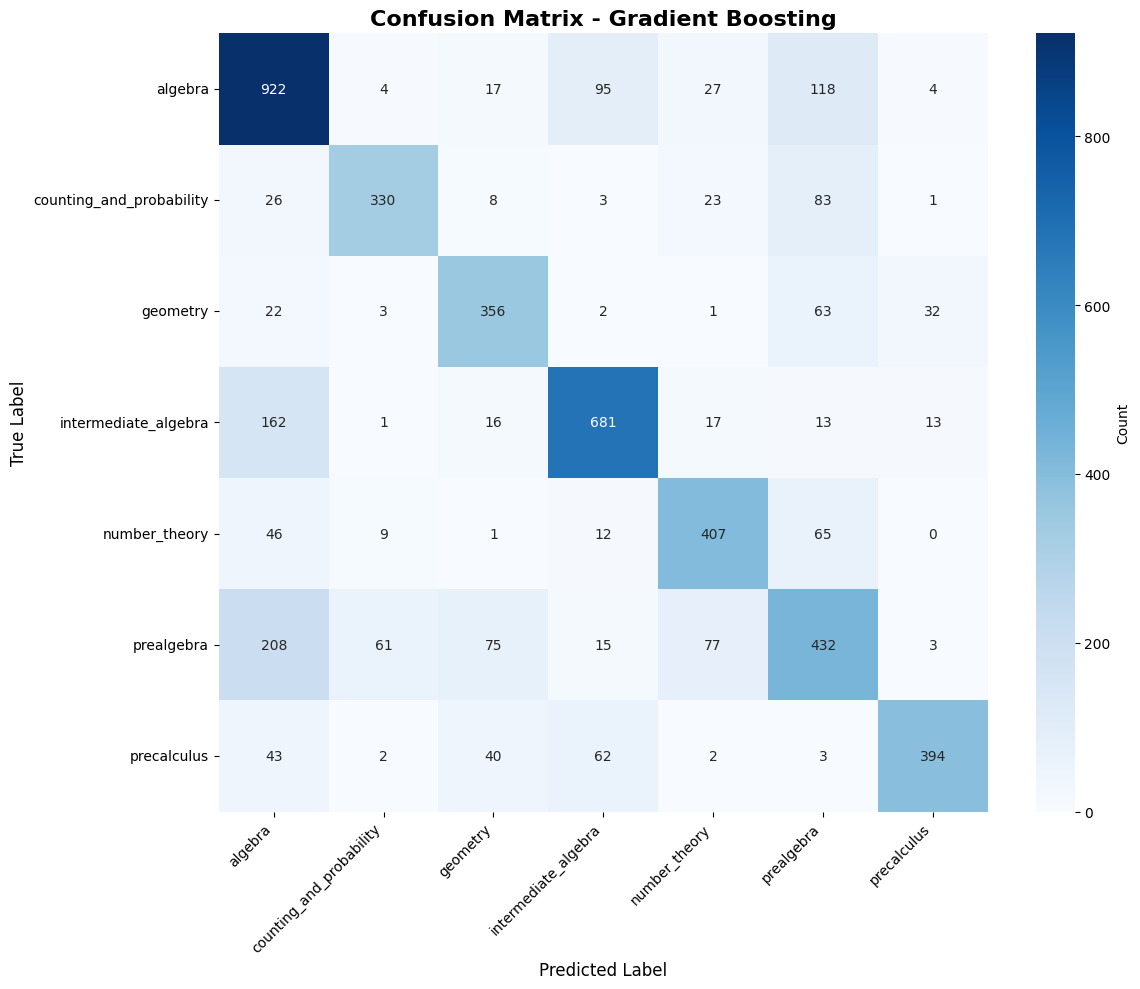


--- Per-Class Metrics ---
                   Class  Precision   Recall  F1-Score  Support
                 algebra   0.645206 0.776748  0.704893     1187
counting_and_probability   0.804878 0.696203  0.746606      474
                geometry   0.693957 0.743215  0.717742      479
    intermediate_algebra   0.782759 0.754153  0.768190      903
           number_theory   0.734657 0.753704  0.744059      540
              prealgebra   0.555985 0.495982  0.524272      871
             precalculus   0.881432 0.721612  0.793555      546

FEATURE IMPORTANCE


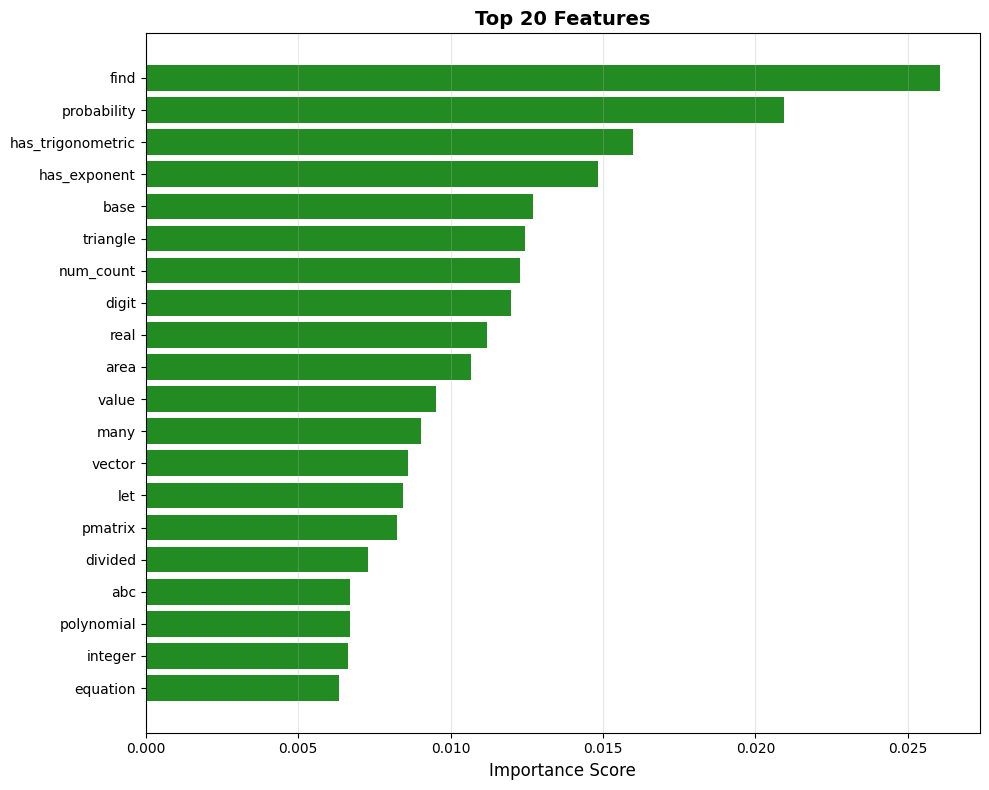

In [65]:
"""
BLOCK 12: DETAILED EVALUATION
==============================
Evaluate best model with detailed metrics
"""

if 'results' not in locals() or 'best_name' not in locals():
    print("ERROR: Run Block 11 first!")
else:
    best_model = results[best_name]['model']

    metrics_df = classifier.evaluate_model(
        best_model, X_test, y_test, best_name
    )

    if hasattr(best_model, 'feature_importances_'):
        print("\n" + "="*80)
        print("FEATURE IMPORTANCE")
        print("="*80)

        feature_names = list(classifier.vectorizer.get_feature_names_out())
        manual_features = [c.replace('feature_', '') for c in train_df_features.columns
                          if c.startswith('feature_')]
        feature_names.extend(manual_features)

        importances = best_model.feature_importances_
        indices = np.argsort(importances)[-20:]

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(indices)), importances[indices], color='forestgreen')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Importance Score', fontsize=12)
        plt.title('Top 20 Features', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

COMPLETE TEST SET EVALUATION

Evaluating on 5000 test samples...

OVERALL PERFORMANCE
Test Accuracy: 0.7044 (70.44%)
Test F1-Score: 0.7040
Correct: 3522/5000
Incorrect: 1478/5000

PER-CLASS PERFORMANCE

                   Topic  Precision   Recall  F1-Score  Support
                 algebra   0.645206 0.776748  0.704893     1187
counting_and_probability   0.804878 0.696203  0.746606      474
                geometry   0.693957 0.743215  0.717742      479
    intermediate_algebra   0.782759 0.754153  0.768190      903
           number_theory   0.734657 0.753704  0.744059      540
              prealgebra   0.555985 0.495982  0.524272      871
             precalculus   0.881432 0.721612  0.793555      546

CONFUSION ANALYSIS

Top Confusion Pairs:
                    True            Predicted  Count
              prealgebra              algebra    208
    intermediate_algebra              algebra    162
                 algebra           prealgebra    118
                 algebra interm

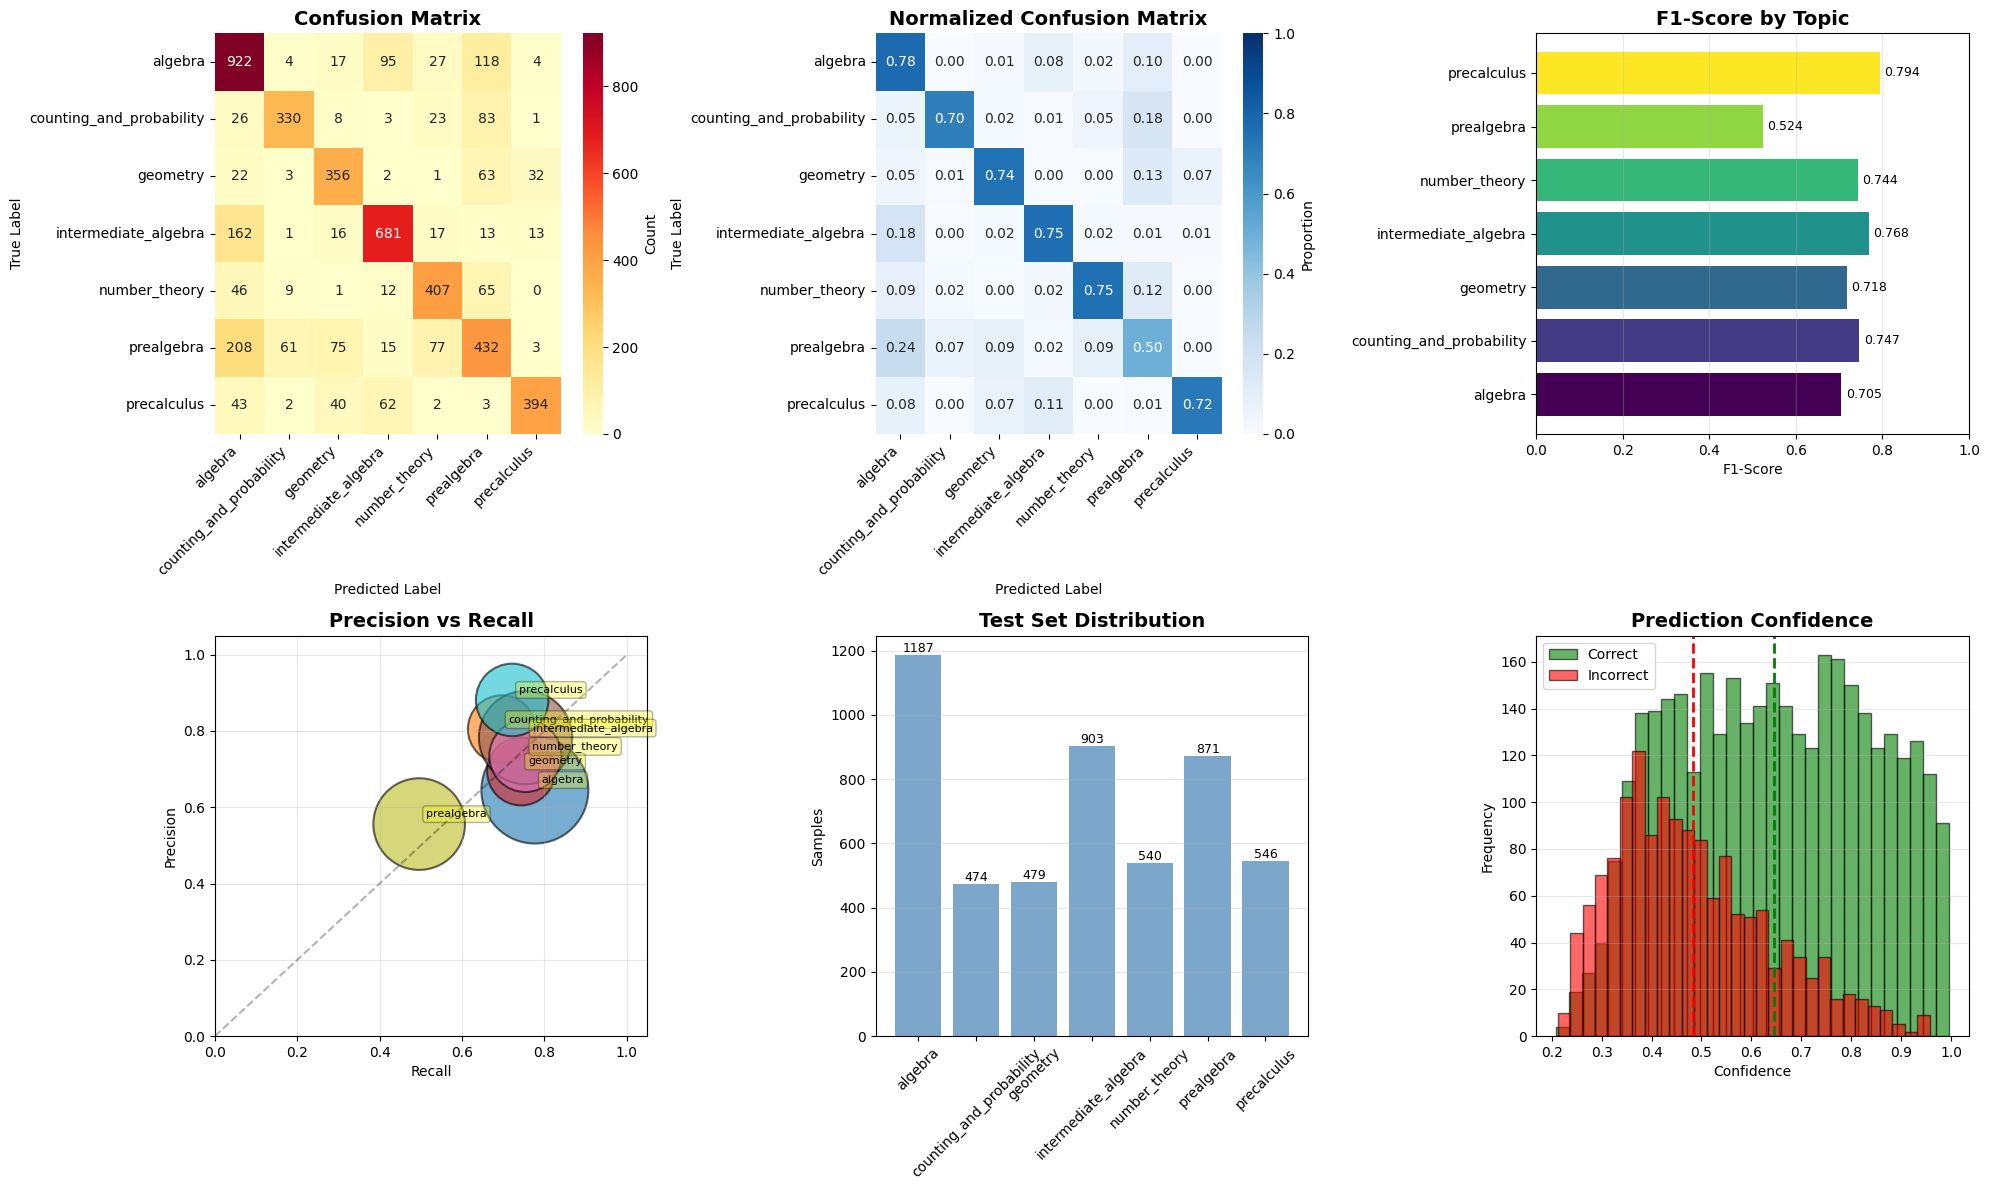


ERROR ANALYSIS

Total Misclassifications: 1478

SUMMARY
Model: Gradient Boosting
Accuracy: 0.7044 (70.44%)
F1-Score: 0.7040
Best Topic: precalculus (F1: 0.7936)
Worst Topic: prealgebra (F1: 0.5243)
Avg Confidence: 0.5968


In [66]:
"""
BLOCK 13: COMPLETE TEST SET ANALYSIS
====================================
Comprehensive evaluation on entire test set
"""

if 'results' not in locals() or 'best_name' not in locals():
    print("ERROR: Run Block 11 first!")
else:
    print("="*80)
    print("COMPLETE TEST SET EVALUATION")
    print("="*80)

    best_model = results[best_name]['model']

    print(f"\nEvaluating on {len(y_test)} test samples...")
    y_pred_full = best_model.predict(X_test)

    has_proba = hasattr(best_model, 'predict_proba')
    if has_proba:
        y_pred_proba = best_model.predict_proba(X_test)

    overall_accuracy = accuracy_score(y_test, y_pred_full)
    overall_f1 = f1_score(y_test, y_pred_full, average='weighted')

    print(f"\n{'='*80}")
    print(f"OVERALL PERFORMANCE")
    print(f"{'='*80}")
    print(f"Test Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"Test F1-Score: {overall_f1:.4f}")
    print(f"Correct: {np.sum(y_pred_full == y_test)}/{len(y_test)}")
    print(f"Incorrect: {np.sum(y_pred_full != y_test)}/{len(y_test)}")

    print(f"\n{'='*80}")
    print(f"PER-CLASS PERFORMANCE")
    print(f"{'='*80}")

    class_report = classification_report(
        y_test, y_pred_full,
        target_names=classifier.label_encoder.classes_,
        output_dict=True
    )

    class_metrics = []
    for topic in classifier.label_encoder.classes_:
        metrics = class_report[topic]
        class_metrics.append({
            'Topic': topic,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1-score'],
            'Support': int(metrics['support'])
        })

    metrics_df = pd.DataFrame(class_metrics)
    print("\n" + metrics_df.to_string(index=False))

    print(f"\n{'='*80}")
    print(f"CONFUSION ANALYSIS")
    print(f"{'='*80}")

    cm = confusion_matrix(y_test, y_pred_full)

    confusion_pairs = []
    for i in range(len(classifier.label_encoder.classes_)):
        for j in range(len(classifier.label_encoder.classes_)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append({
                    'True': classifier.label_encoder.classes_[i],
                    'Predicted': classifier.label_encoder.classes_[j],
                    'Count': cm[i, j]
                })

    confusion_df = pd.DataFrame(confusion_pairs).sort_values('Count', ascending=False)

    if len(confusion_df) > 0:
        print("\nTop Confusion Pairs:")
        print(confusion_df.head(10).to_string(index=False))

    # Comprehensive Visualizations
    fig = plt.figure(figsize=(20, 12))

    # 1. Confusion Matrix
    ax1 = plt.subplot(2, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                xticklabels=classifier.label_encoder.classes_,
                yticklabels=classifier.label_encoder.classes_,
                cbar_kws={'label': 'Count'}, ax=ax1)
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # 2. Normalized Confusion Matrix
    ax2 = plt.subplot(2, 3, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classifier.label_encoder.classes_,
                yticklabels=classifier.label_encoder.classes_,
                cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1, ax=ax2)
    ax2.set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # 3. F1-Scores by Topic
    ax3 = plt.subplot(2, 3, 3)
    f1_scores = metrics_df['F1-Score'].values
    topics = metrics_df['Topic'].values
    colors = plt.cm.viridis(np.linspace(0, 1, len(topics)))
    bars = ax3.barh(topics, f1_scores, color=colors)
    ax3.set_xlabel('F1-Score')
    ax3.set_title('F1-Score by Topic', fontsize=14, fontweight='bold')
    ax3.set_xlim([0, 1])
    ax3.grid(axis='x', alpha=0.3)
    for i, (bar, score) in enumerate(zip(bars, f1_scores)):
        ax3.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=9)

    # 4. Precision vs Recall
    ax4 = plt.subplot(2, 3, 4)
    precision_scores = metrics_df['Precision'].values
    recall_scores = metrics_df['Recall'].values
    ax4.scatter(recall_scores, precision_scores, s=metrics_df['Support']*5,
                c=range(len(topics)), cmap='tab10', alpha=0.6,
                edgecolors='black', linewidth=1.5)
    for i, topic in enumerate(topics):
        ax4.annotate(topic, (recall_scores[i], precision_scores[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision vs Recall', fontsize=14, fontweight='bold')
    ax4.set_xlim([0, 1.05])
    ax4.set_ylim([0, 1.05])
    ax4.grid(True, alpha=0.3)
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.3)

    # 5. Test Set Distribution
    ax5 = plt.subplot(2, 3, 5)
    support_counts = metrics_df['Support'].values
    bars = ax5.bar(topics, support_counts, color='steelblue', alpha=0.7)
    ax5.set_ylabel('Samples')
    ax5.set_title('Test Set Distribution', fontsize=14, fontweight='bold')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(axis='y', alpha=0.3)
    for bar, count in zip(bars, support_counts):
        ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{int(count)}', ha='center', va='bottom', fontsize=9)

    # 6. Confidence Distribution
    ax6 = plt.subplot(2, 3, 6)
    if has_proba:
        max_probabilities = np.max(y_pred_proba, axis=1)
        correct_mask = y_pred_full == y_test
        ax6.hist(max_probabilities[correct_mask], bins=30, alpha=0.6,
                label='Correct', color='green', edgecolor='black')
        ax6.hist(max_probabilities[~correct_mask], bins=30, alpha=0.6,
                label='Incorrect', color='red', edgecolor='black')
        ax6.set_xlabel('Confidence')
        ax6.set_ylabel('Frequency')
        ax6.set_title('Prediction Confidence', fontsize=14, fontweight='bold')
        ax6.legend()
        ax6.grid(axis='y', alpha=0.3)
        avg_conf_correct = np.mean(max_probabilities[correct_mask])
        avg_conf_incorrect = np.mean(max_probabilities[~correct_mask])
        ax6.axvline(avg_conf_correct, color='green', linestyle='--', linewidth=2)
        ax6.axvline(avg_conf_incorrect, color='red', linestyle='--', linewidth=2)
    else:
        ax6.text(0.5, 0.5, f'{best_name}\nNo probability support',
                ha='center', va='center', fontsize=12, transform=ax6.transAxes)
        ax6.axis('off')

    plt.tight_layout()
    plt.show()

    # Error Analysis
    print(f"\n{'='*80}")
    print(f"ERROR ANALYSIS")
    print(f"{'='*80}")

    misclassified_indices = np.where(y_pred_full != y_test)[0]
    print(f"\nTotal Misclassifications: {len(misclassified_indices)}")

    # Summary
    print(f"\n{'='*80}")
    print(f"SUMMARY")
    print(f"{'='*80}")
    print(f"Model: {best_name}")
    print(f"Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"F1-Score: {overall_f1:.4f}")
    print(f"Best Topic: {metrics_df.loc[metrics_df['F1-Score'].idxmax(), 'Topic']} (F1: {metrics_df['F1-Score'].max():.4f})")
    print(f"Worst Topic: {metrics_df.loc[metrics_df['F1-Score'].idxmin(), 'Topic']} (F1: {metrics_df['F1-Score'].min():.4f})")
    if has_proba:
        print(f"Avg Confidence: {np.mean(np.max(y_pred_proba, axis=1)):.4f}")
    print(f"{'='*80}")

In [67]:
import pickle
model_data = {
    'model': classifier.best_model,
    'vectorizer': classifier.vectorizer,
    'scaler': classifier.scaler,
    'label_encoder': classifier.label_encoder
}
with open('model.pkl', 'wb') as f:
    pickle.dump(model_data, f)